<a href="https://colab.research.google.com/github/TeddyBach/Exoplanet-Detection/blob/main/Student_PlanetHunters_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>


# Classifying Exoplanets

For satellite missions, NASA needs to be able to process tons and tons of information received by satellites efficiently and effectively. We'll see one approach as to help NASA classify exoplanet stars by using modern machine learning techniques! How better to learn than use raw data from one of NASA's satellites?


The focus of this notebook is classifying exoplanet stars. We'll be:
*   Preprocessing the dataset for the ML models
*   Implementing different ML architectures to see which one performs best
*   Using data augmentation to improve our models' performance!

## Exoplanet Classification




Previously, we were able to visualize data of the training set from Kepler. Now that we better understand the data that we're working with, we can begin to dive into how we can train a computer to classify exoplanet stars, and the difficulties faced when doing so.

We can make use of different architectures and models to explore the best options for classifying exoplanet stars. Our explorations will also help us build intuition of how to analyze and use raw data from a satellite to help plan future missions exploring the abyss that is space around us. Is there life elsewhere? Right now we're not too sure, but identyfying and analyzing exoplanets can help us to better understand where we're most likely to find life!

**IMPORTANT**: Since the calculations used for machine learning can be demanding for a computer, we need to do one step before continuing. Please go to the 'Runtime' tab, and click on 'Change Runtime Type'; then select **GPU** under the dropdown for Hardware accelerator.

In [ ]:
#@title Run this code to get started
%tensorflow_version 2.x
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
--2023-08-11 18:24:37--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [application/octet-stream]
Saving to: ‘exoTrain.csv’

exoTrain.csv        100%[===================>] 250.08M  22.7MB/s    in 12s     

2023-08-11 18:24:49 (20.6 MB/s) - ‘exoTrain.csv’ saved [262223348/262223348]

--2023-08-11 18:24:49--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.12

Remember that `df_train` and `df_test` are the Pandas Dataframes that store our training, validation, and test datapoints. The training dataset is the one we explored last time, and the testing dataset is a new one!

## Milestone 1: Understanding our Data



### Data Visualization

Let's make sure that the data we've extracted has properly loaded. **Please print the length of each dataframe (`df_train` and `df_test`) and the first five values from `df_train`.**


In [ ]:
#YOUR CODE HERE
print(len(df_train))
print(len(df_test))
df_train.head()

5087
570


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


**Question / Review**: What do the columns represent?

#### Comparing Flux Curves for Exoplanets vs. Non-Exoplanets

Let's review what exoplanet stars look like. What patterns do you notice in these examples from the training set?

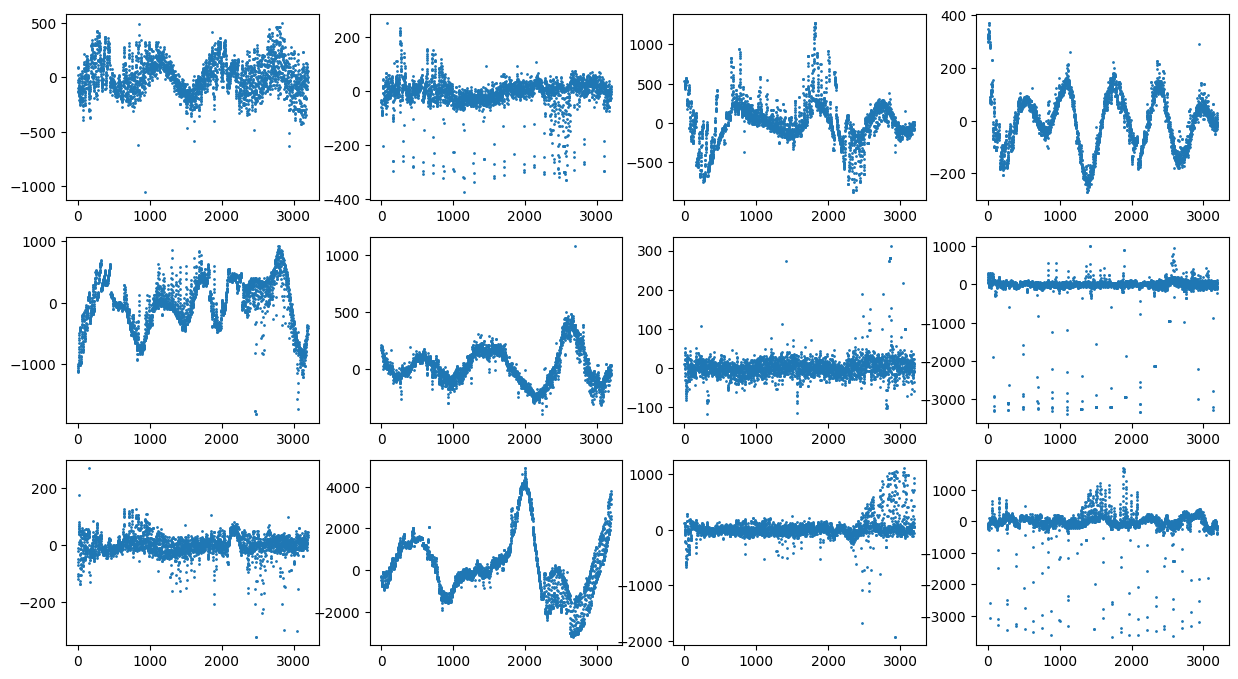

In [ ]:
#@title Run to see samples of exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL'] == 1].iloc[i,1:],s=1)

And now let's review what *non*-exoplanet stars look like! What patterns do you notice in these examples from the training set?

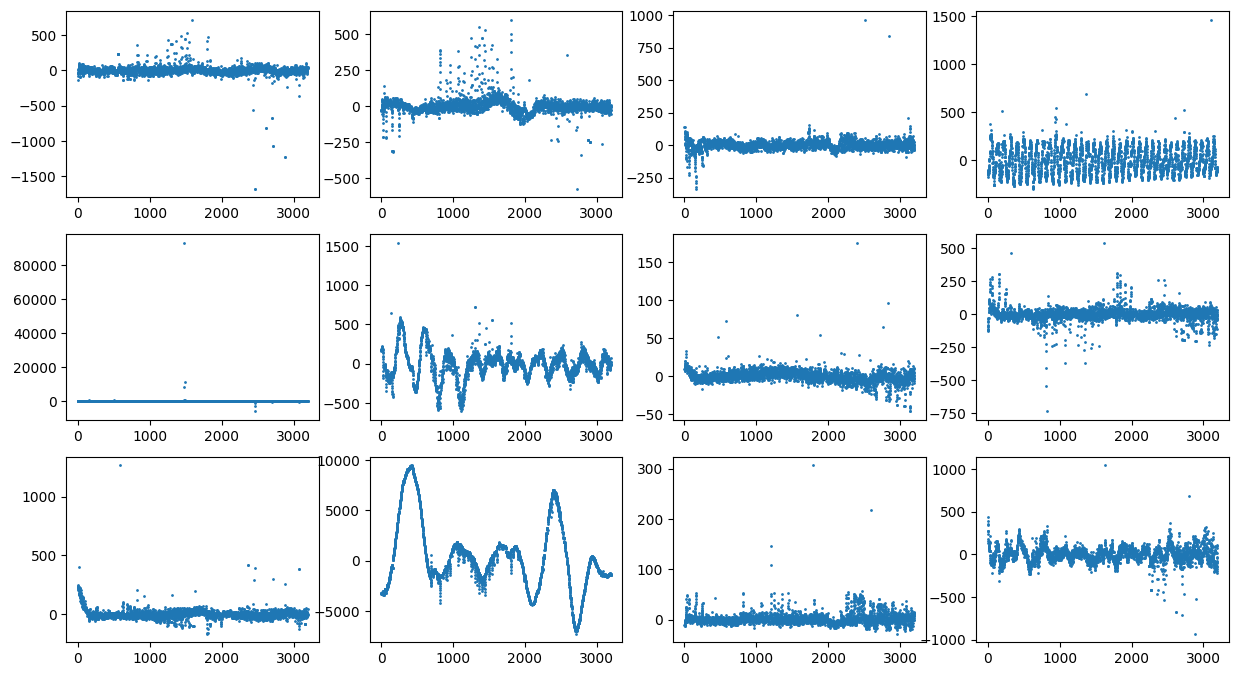

In [ ]:
#@title Run to see samples of non-exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL']==0].iloc[i,1:],s=1)

**Discuss**

What are some differences we notice between exoplanet stars vs. non-exoplanet stars?

#### (Optional) Comparing Histograms for Exoplanets vs. Non-Exoplanets

Histograms allow us to view how many times a certain value is present within a given sample. For example, this would be like counting how many times a particular value was observed. On the bottom or x-axis, this would be all of the different values of flux observed. The y-axis would represent how many times those values were observed throughout the sample.

**Question**

The y-value of a histogram will never have a negative value. Why?

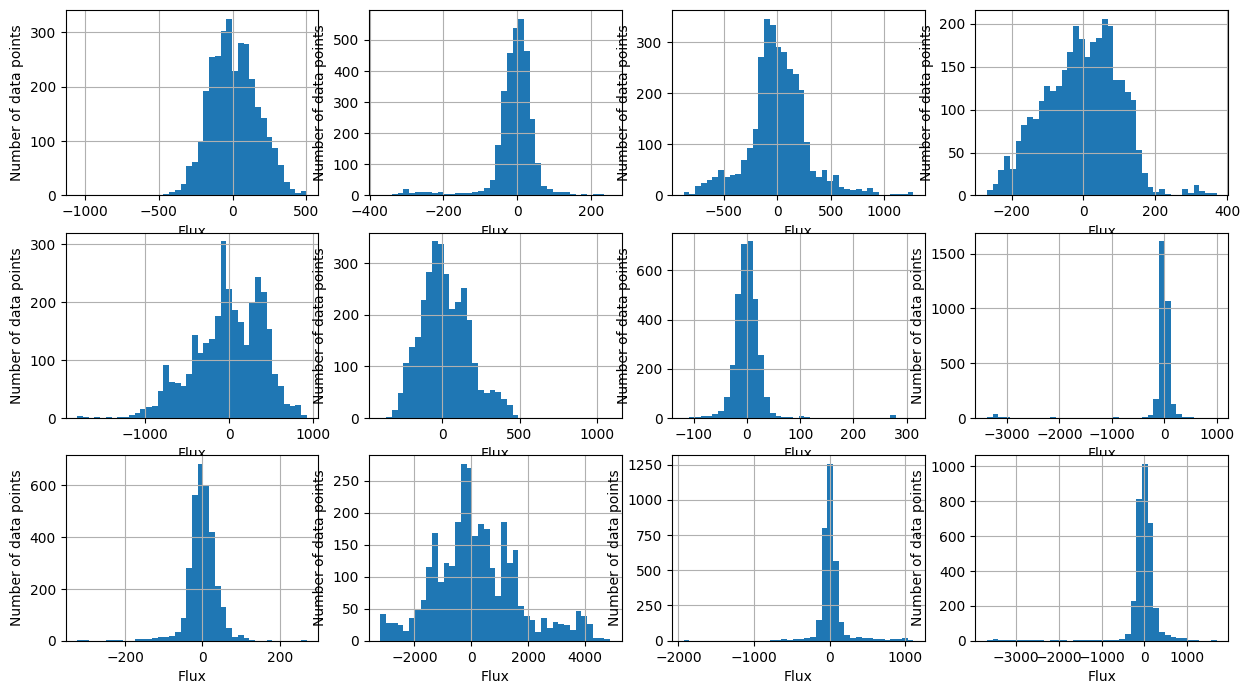

In [ ]:
#@title Run to see histograms of exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==1].iloc[i,1:].hist(bins=40)

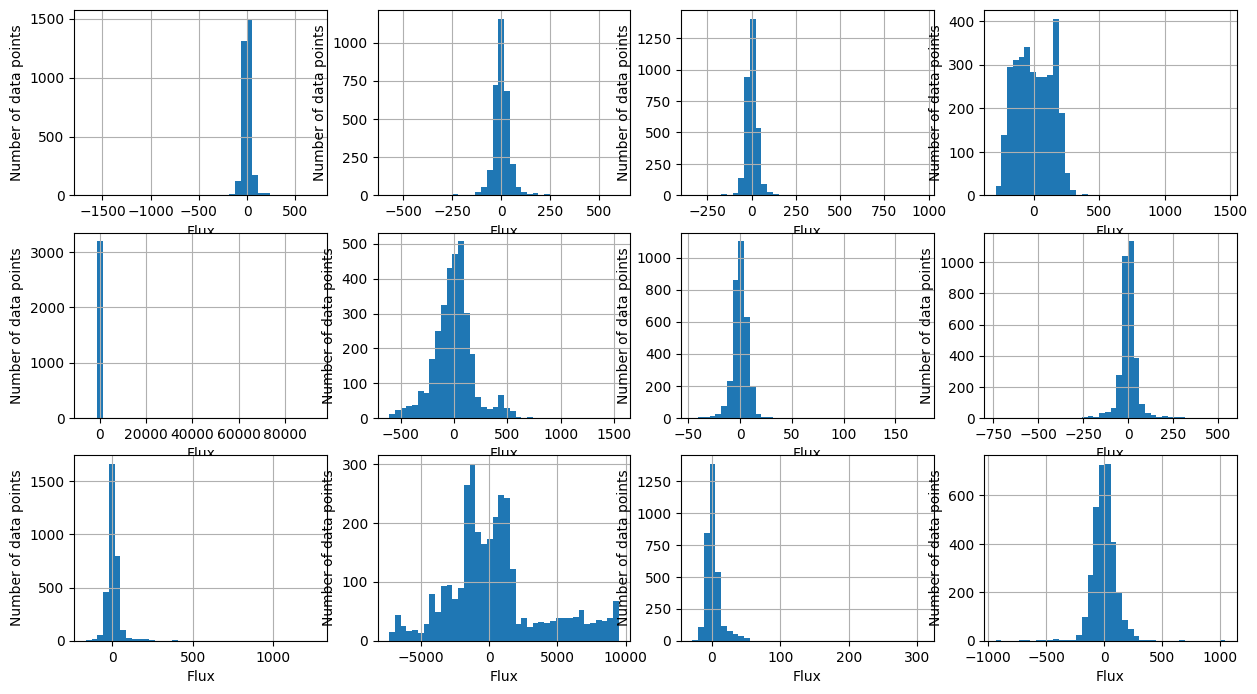

In [ ]:
#@title Run to see histograms of non-exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==0].iloc[i,1:].hist(bins=40)

**Discuss:**
- What do you notice about the range of values in exoplanet vs. non-exoplanet stars?
- How could this be a problem? Is there a way to deal with it?

In [ ]:
"""
Enter your answer here
"""

'\nEnter your answer here\n'

### Counting Exoplanets

In `df_train`, how many samples are from an exoplanet star? How many are non-exoplanet-stars? How about in `df_test`?

As in Notebook 1, please use [`.loc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) to separate out the data frames, and then `len` to print out the length of each.

In [ ]:
#YOUR CODE HERE
non_exo_data=df_train.loc[df_train.LABEL==0]
exo_data = df_train.loc[df_train.LABEL==1]

print(len(non_exo_data))
print(len(exo_data))

print(len(exo_data) / len(df_train) * 100, '%')

5050
37
0.7273442107332416 %


In [ ]:
non_exo_data=df_test.loc[df_test.LABEL==0]
exo_data = df_test.loc[df_test.LABEL==1]

print(len(non_exo_data))
print(len(exo_data))

print(len(exo_data) / len(df_test) * 100, '%')

565
5
0.8771929824561403 %


Now, please calculate the **portion** of exoplanet stars compared to the total samples, in both the traning data and the testing data.

In [ ]:
#YOUR CODE HERE



That's less than 1 percent!

**Discuss:** What problems could the calculated ratios pose? What does this mean in terms of searching for habitable planets?

In [ ]:
"""
Enter your answer here
"""

'\nEnter your answer here\n'

## Milestone 2: Classification with KNN

Now, let's approach our problem as a classification task! Based on our flux data, does each data point represent an exoplanet star or a non-exoplanet star?

In [ ]:
#@title Run this to load helper functions and create train_X, train_y, test_X, test_y

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    ConfusionMatrixDisplay.from_estimator(model,train_X,train_y)
    plt.show()
    print("Testing:")
    ConfusionMatrixDisplay.from_estimator(model,test_X,test_y)

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

#### Step 1: Create our model

Let's start by using a `KNeighborsClassifier` model, which has already been imported from [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [ ]:
# Create a KNN model (will train later)

#YOUR CODE HERE
n_neighbors = 5

model = KNeighborsClassifier(n_neighbors = n_neighbors)


####Step 2: Train our model

Now train the KNN model defined on `train_X` and `train_y` using the `fit` method.

In [ ]:
# Train the model
model.fit(train_X, train_y)

KNeighborsClassifier()

#### Step 3: Predictions and Accuracy

Now calculate the `train_predictions` and `test_predictions` using the `predict` function from our model. Then print out the results from using `accuracy_score`, previously imported from `sklearn.metrics`. This may take a while to run!

In [ ]:
# Calculate the predictions and accuracies on train_X and test_X
# using our trained model

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

train_accuracy = accuracy_score(train_y, train_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

print(train_accuracy)
print(test_accuracy)


####################

0.9931197169254964
0.9912280701754386


Awesome! Is this a good level of accuracy to have? What kind of problem are we seeing?

**Hint:** What would happen if we predict every sample as a non-exoplanet star?

#### Step 4: Confusion Matrices

Confusion Matrices are helpful in understanding how our model's doing and the kinds of biases it might have - even if it has a high accuracy. This might change how much we trust our model!

**Use the `analyze_results` function** to analyze the results of the model. This may take a while to run.

-------------------------------------------
Model Results

Training:


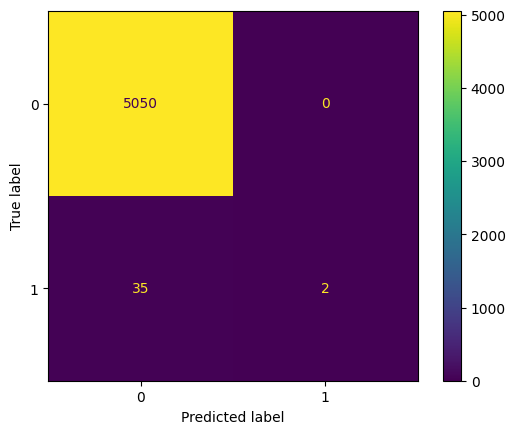

Testing:


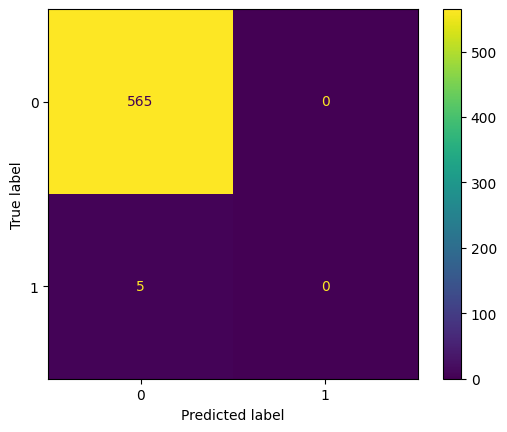

In [ ]:
#Analyze the KNN model
#YOUR CODE HERE

analyze_results(model, train_X, train_y, test_X, test_y)

0.9939060349911539
0.9912280701754386
-------------------------------------------
Model Results

Training:


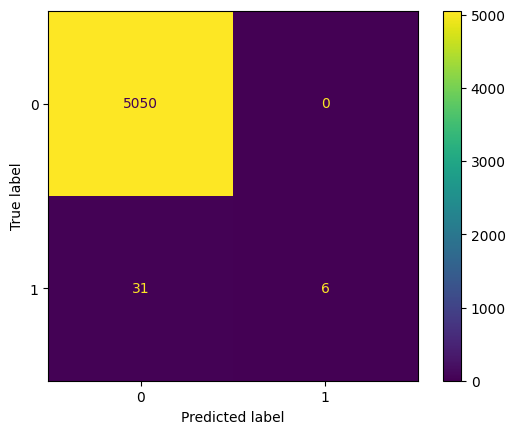

Testing:


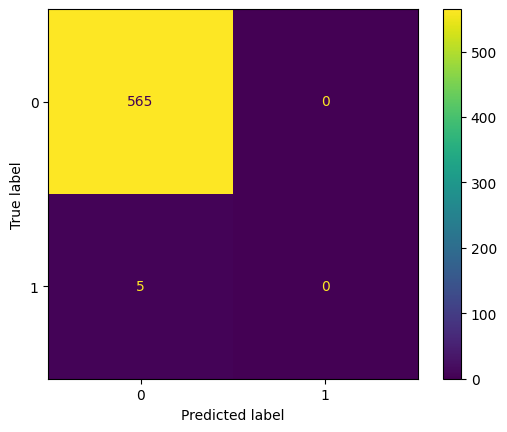

In [ ]:
n_neighbors =2

model = KNeighborsClassifier(n_neighbors = n_neighbors)

model.fit(train_X, train_y)

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

train_accuracy = accuracy_score(train_y, train_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

print(train_accuracy)
print(test_accuracy)

analyze_results(model, train_X, train_y, test_X, test_y)

**Discuss**

Were the results what you were expecting? What could we do to make it better?

Try **experimenting with changing the number of neighbors** to see if we can get better results!

In [ ]:
"""
Enter your answer here
"""

'\nEnter your answer here\n'

## Milestone 3: Logistic Regression

You might feel less confident in your KNN model after seeing the confusion matrix! Let's try out some other models.


Here, let's do what we did before, but using a Logistic Regression model instead of a KNN model! Please set up a model using the imported `LogisticRegression` object with `max_iter`=1000.

In [ ]:
# Create a Logistic Regression model (will train later)

max_iter = 1000

#YOUR CODE HERE
logmodel = LogisticRegression(max_iter = max_iter)

Now train and analyze your `model` like you did before, using both accuracy and confusion matrices.

0.9272655789266758
0.6508771929824562
-------------------------------------------
Model Results

Training:


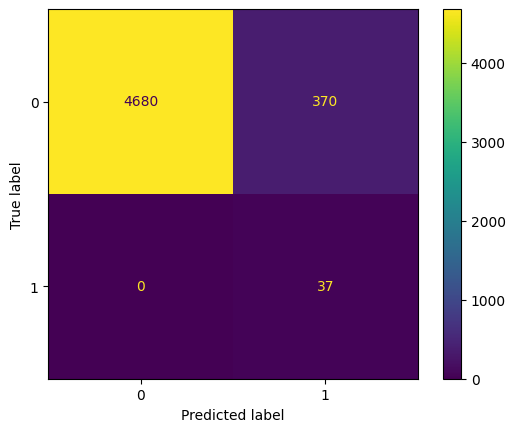

Testing:


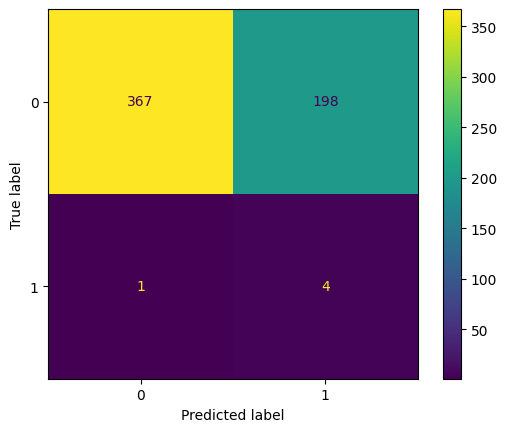

In [ ]:
#YOUR CODE HERE

logmodel.fit(train_X, train_y)

train_predictions = logmodel.predict(train_X)
test_predictions = logmodel.predict(test_X)

train_accuracy = accuracy_score(train_y, train_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

print(train_accuracy)
print(test_accuracy)

analyze_results(logmodel, train_X, train_y, test_X, test_y)

**Discuss:** What are the pros and cons of this model compared to the previous one? Which one would you prefer to use?

## Milestone 4: Exploring Other Models

Now, let's see if we can find another classifier that combines the best of both worlds!

Check out the [list of classifiers](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) from Scikit-learn.

Choose some classifiers and try them out. Try adjusting the model parameters, too! How good can you get the results?

Don't forget to import any necessary libraries.

Now create a model and don't forget to import any necessary libraries!

In [ ]:
#YOUR CODE HERE to experiment with creating and importing models!

**Discuss:** Which model performed best? What can we consider as "good" performance?

## Milestone 5: Data Augmentation


In the previous training techniques, we noticed that the models may have had high levels of accuracy, but yielded poor results!

Here, we'll try to improve performance using data augmentation. We'll apply five different augmentation techniques to this dataset, and explore two of these techniques in high detail. Together, we'll explore the use and importance of these two concepts, and compare these results with the previous results we've had as a baseline.

In [ ]:
#@title Run to define helper functions
# Helper functions that we can run for the three augmentation functions that will be used, but not explroed in depth

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

Previously, we've discussed how our data can be improved. Here we'll further explore two points of previous concern:
1. Data having a high range of values
2. Data being heavily unbalanced (towards non-exoplanet stars)

### Normalization

Normalization means scaling data so all points lie between 0 and 1.

For example, if we were to normalize the following list of values:

[0, 1, 2, 3, 4, 5]

the normalized list would be:

[0, 0.2, 0.4, 0.6, 0.8, 1]

**Discuss**:
What operations happen to normalize the list? What happens if there's a negative value? How can we generalize this into a formula?

**Example**

What are the normalized values for the following list? (To two decimal places)

[-1, -2, 4, 5]


In [ ]:
#@title Answer fields
"""
Enter your answer here
"""
value_1 =  .14#@param {type:"number"}
value_2 = 0 #@param {type:"number"}
value_3 = .86 #@param {type:"number"}
value_4 = 1 #@param {type:"number"}

Make sure to run the code block above to save your answers! Then run the code block below to check your answers.

In [ ]:
#@title Run this to check answers

print("Value 1:", value_1 == 0.14)
print("Value 2:", value_2 == 0)
print("Value 3:", value_3 == 0.86)
print("Value 4:", value_4 == 1.0)

Value 1: True
Value 2: True
Value 3: True
Value 4: True


Let's create a function that will help us do this. Explore the functions from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) and use one to help us create a function to `normalize` our `train_X` and `test_X`. Complete the function `norm`.

In [ ]:
def norm(train_X, test_X):
  norm_train_X = normalize(train_X)
  norm_test_X = normalize(test_X)
  return norm_train_X, norm_test_X

Now let's apply this concept to our `train_X` and `test_X` variables using the previously defined helper-function called `norm`. We'll use it alongside a couple of other preprocessing functions.

**Hint**: Use the first two lines of code as inspiration.

In [ ]:
fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)

#####TODO#########
norm_train_X, norm_test_X = norm(savgol_train_X, savgol_test_X)
##################

robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)

**Discuss:** Why don't we normalize our labels?

### Data Augmentation with SMOTE

Now to tackle the problem of having an imbalanced dataset! The concept that we'll use to approach this is by synthesizing new data based off of our existing to create a more balanced dataset. Essentially, we'll be creating new datapoints to have more exoplanet samples.

We'll accomplish this by using SMOTE.

SMOTE generates new data for the minority class to help balance the dataset, and to better help define classifcation regions - so the model doesn't always predict the majority class.

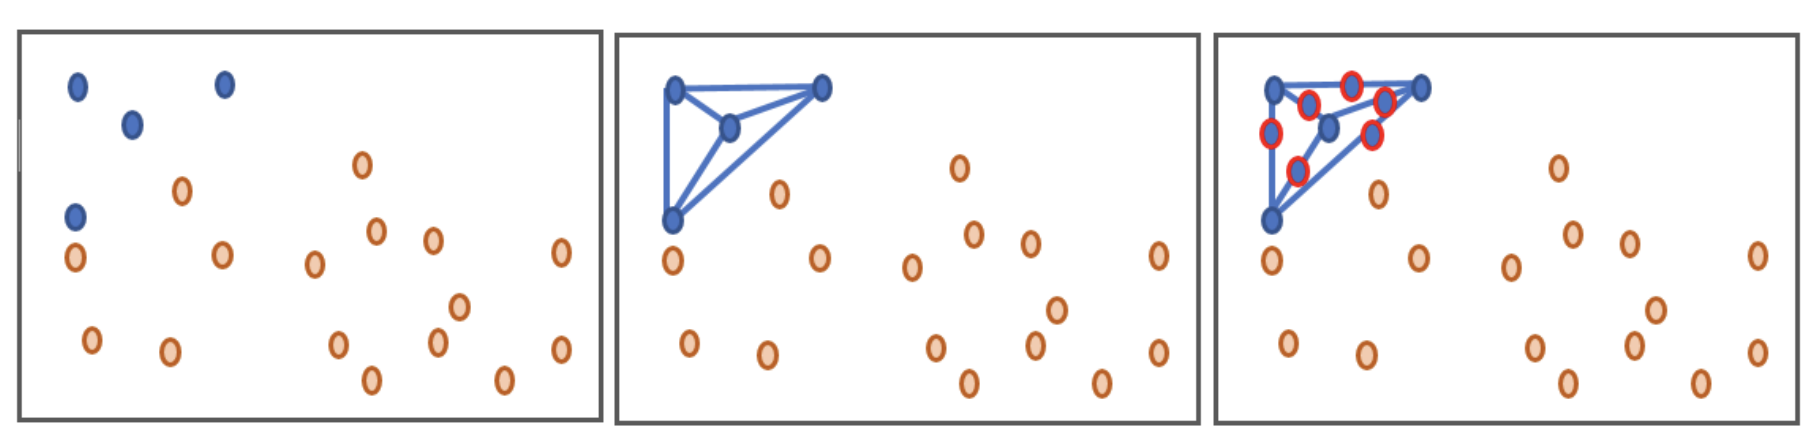

You can learn more about SMOTE [here](https://datasciencecampus.github.io/balancing-data-with-smote/).

Let's now apply this concept by generating new datapoints in `robust_train_X` and `train_y` using our predefined helper-function `smote`.

You might find our graphs looking sigificantly different from the data set we started with! This is the power of data pre-processing with normalization, filters, transformations, and SMOTE, we can both modify our data to look cleaner and also to have more samples in our dataset.


In [ ]:
#YOUR CODE HERE
smote_train_X, smote_train_y = smote(robust_train_X, train_y)

Amazing, now we have our SMOTE-augmented training data and labels. Now, let's go ahead and attempt to visualize this new augmented data.

In [ ]:
#@title Run to load helper functions and variables
def visualize_data(X, y, indicies):
  stars = indicies

  fig = plt.figure(figsize=(24,500))
  x = np.array(range(3197))
  for i in range(0,len(stars)):
      ax = fig.add_subplot(100,5,1+i)
      ax.set_title('Data '+"I:"+str(stars[i])+" Label:"+str(y[stars[i]]))
      ax.scatter(x, X[stars[i],:],s=1)

robust_train_y_with_exoplanet_indicies = train_y.nonzero()[0]
robust_train_y_with_no_exoplanet_indicies = (train_y-1).nonzero()[0]

smote_train_y_with_exoplanet_indicies = smote_train_y.nonzero()[0]
smote_train_y_with_no_exoplanet_indicies = (smote_train_y-1).nonzero()[0]

Orginal, newly modified data with exoplanets:


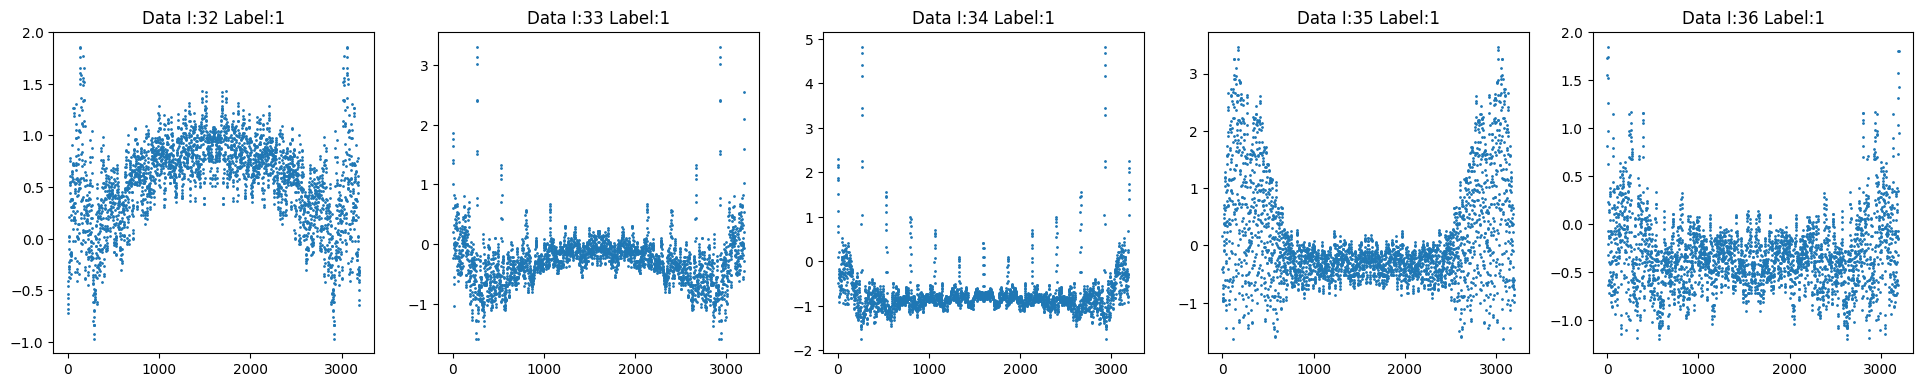

In [ ]:
#@title Run to visualize original, preprocessed data with exoplanets
print("Orginal, newly modified data with exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_exoplanet_indicies[-5:])

Augmented data with Exoplanets:


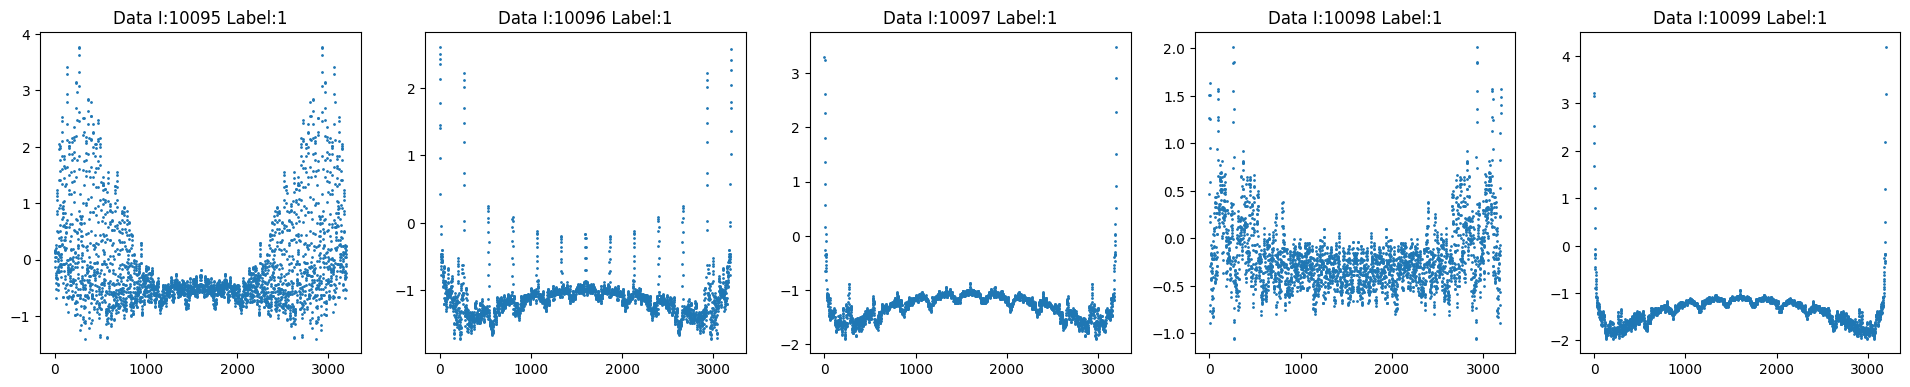

In [ ]:
#@title Run to visualize newly generated data containing exoplanets
print("Augmented data with Exoplanets:")
visualize_data(smote_train_X, smote_train_y, smote_train_y_with_exoplanet_indicies[-5:])

**Discuss: How do these plots compare to the plots without SMOTE? What's similar and different about them?**

Orginal, newly modified data with no exoplanets:


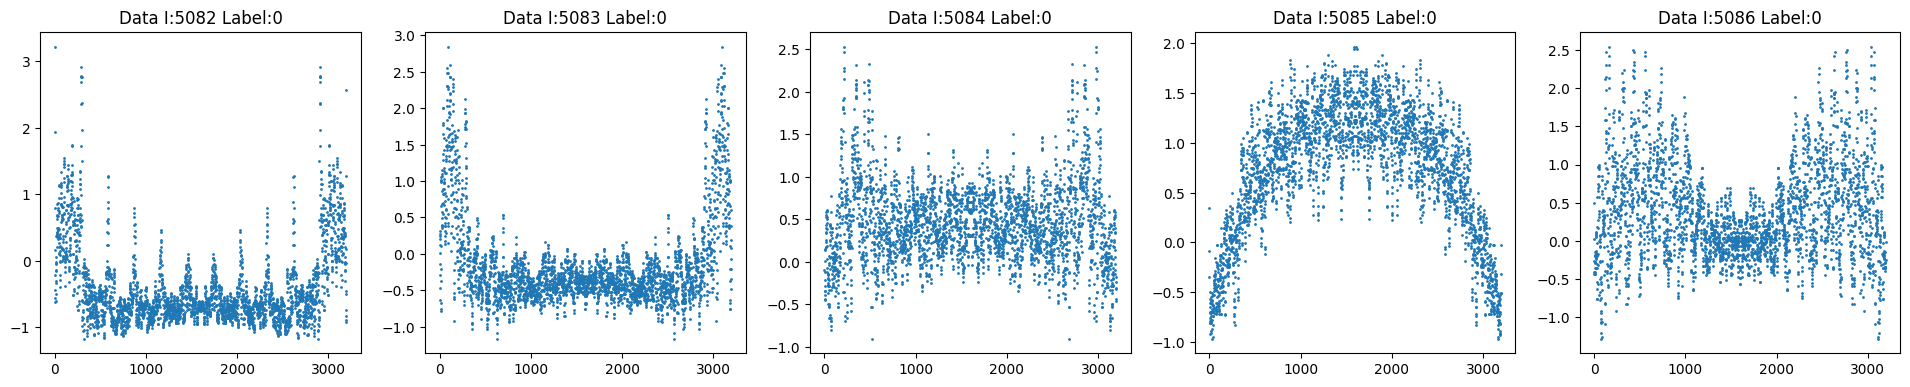

In [ ]:
#@title Run to visualize original, modified data with no Exoplanets
print("Orginal, newly modified data with no exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_no_exoplanet_indicies[-5:])

Augmented data with no Exoplanets:


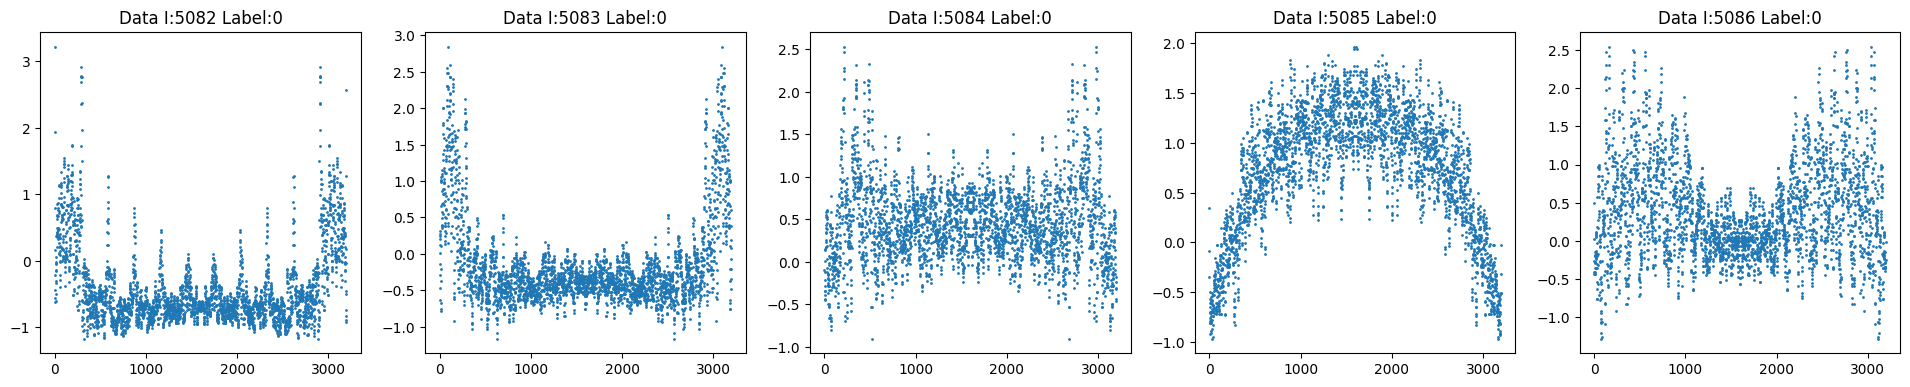

In [ ]:
#@title Run to visualize newly generated data containing no exoplanets
print("Augmented data with no Exoplanets:")
visualize_data(smote_train_X, smote_train_y, smote_train_y_with_no_exoplanet_indicies[-5:])

**Discuss: What's the difference between these plots? Do they look similar — if so, why?**


**Explore:** How many training samples do we have now? How many are exoplanet samples? How many are non-exoplanet samples? What things do you notice? What's different?

In [ ]:
#YOUR CODE HERE

print("train_y len:", len(smote_train_y))

number_of_exoplanet_samples = np.count_nonzero(smote_train_y == 1)
number_of_non_exoplanet_samples = np.count_nonzero(smote_train_y == 0)

print("exoplanet samples in train_y:", number_of_exoplanet_samples)
print("non-exoplanet samples in train_y:", number_of_non_exoplanet_samples)

train_y len: 10100
exoplanet samples in train_y: 5050
non-exoplanet samples in train_y: 5050


That looks more balanced!

**Discuss:** What are some things we notice with this new split ratio? What are some things that we expect to happen?

### Milestone 6: Using Augmented Data


Now let's find out how the augmentation affects the results with a past architecture using the new data.
Pick the model that performed best from before and re-train it with the new augmented data. How did we do?

1.0
0.9508771929824561
-------------------------------------------
Model Results

Training:


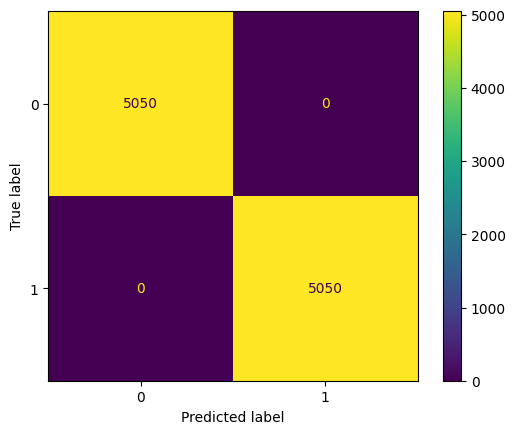

Testing:


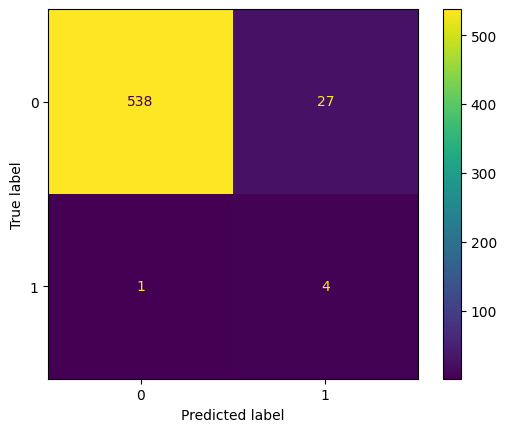

In [ ]:
#YOUR CODE HERE to re-train your model

n_neighbors =2

model = KNeighborsClassifier(n_neighbors = n_neighbors)

model.fit(smote_train_X, smote_train_y)

train_predictions = model.predict(smote_train_X)
test_predictions = model.predict(robust_test_X)

train_accuracy = accuracy_score(smote_train_y, train_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

print(train_accuracy)
print(test_accuracy)

analyze_results(model, smote_train_X, smote_train_y, robust_test_X, test_y)

**Discuss**

Is this better or worse? Why or why not?

**Discuss**: What mistakes did our classifier make? Why do you think our classifier made these mistakes, and what could possibly improve the predictions?